<center>
    <b>RNAge Final Report</b>
    <br>
    <a>
        https://github.com/edgeslab/cs418-project-RNAge/blob/master/Final_Report.ipynb
    </a>
</center>

In [4]:
#Setting up the environment and importing the necessary data
%run Final_source_code/Init.py
%matplotlib inline

### Introduction

Omics are the holy grail of biological discovery. In short, it is the investigation of a certain class of components in a biological smaples. Genomics refers to the study of the whole genome, transcriptomics the whole of the RNA transcripts, and proteomics the whole of the proteins. These are only a few of the *omics*. This approach enables investigation of cellular processes with greater scope than ever before.

Our team of interdisciplinary students knew from the onset that we wanted to leverage this approach towards biological question. Rather than picking a mainstream topic such as cancer, our team chose to investigate human aging on a transcriptomic level. Our fundamental questions entering this project were as follows:
- What genes are associated in aging in different tissues?
- Are different tissues equally related to aging?

These are biologically significant questions as pre-omics research has focused on specific genes of interest or tissue-specific aging. We intend to compare the aging process between tissues and identify associated genes on an omic level.
#### Genes, RNA, and Proteins

<img src="./Final_source_code/simple_central_dogma.png" style="width: 500px;"/>

This is a simplified version of the central dogma which states that DNA, the linear *book* of information in each cell, is selectively **transcribed** into RNA, which is then **translated** into protein, the complex molecules which perform functions in biology. Though each cell in a complex organmism such as a human has the same DNA in all of its cells, the amounts of each gene that ultimately becomes protein is different. These differences are all part of differentiation which enables the innumerable cell types that comprise a human body.

The process is like reading from a book where the book is DNA in a cell. Each tissue has a differently annotated version of the same book; different tissues read different parts of the book. Thus, each tissue has a different fingerprint of which proteins it creates. There are innumerable complexities underlying this simple explanation, but understanding that fingerprint of the cellular identity enables us to understand how tissues and cells work.

#### Transcriptome
The transcriptome is the collection of all transcripts in a sample, which are just strands of RNA. Collecting and analyzing the transcripts in a sample is tantamount to analyzing the proteins in a cell because transcripts are assumed destined to become proteins. Measuring protein on an omic level is very difficult; however, measuring transcripts is a simple matter of sequencing.

Experimentally, mRNA, the stable version of transcripts, is extracted from a sample. These transcript are then sequenced using one of any Next-generation Sequencing platforms. The rawest form of the data consists 75-150 base-pair sequences. A common experiment may generate 50 million of these reads. These reads are then aligned to a genome, human in our case, to identify what gene each transcript fragment belongs to. The relative number of fragments aligning to a given gene is related to the abundance of that transcript, which as we know, is tantamount to knowing how much of that protein is being produced.

This process is called **RNA-sequencing** and will be the type of data used in this project.

### Data

#### Source, Acquisition, Structure, and Granularity

Our team used the Genotype-Tissue Expression (GTEx) project for our transcriptome data. Their efforts consist of genotyping and RNA-sequencing 11,688 tissue samples from 752 subjects across 53 tissues. This means our data is of **fine granularity** on a sample level, but the data is somewhat **coarse** on a subject level. Multiple samples are from single subjects, which means each sample is not entirely independent from one another.

We downloaded the data as the final gene-transcript counts, the number of reads experimentally aligned to a given gene. This looks like a **sparse** matrix with 56,202 features (genes). We also obtained sample metadata for the 11K samples and subject metadata for the 752 subjects.

<u>Data source:</u> https://gtexportal.org/home/datasets
<br>
- [Gene counts](https://storage.googleapis.com/gtex_analysis_v7/rna_seq_data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_reads.gct.gz)
    * 11,688 x 56,202 TSV
- [Sample metadata](https://storage.googleapis.com/gtex_analysis_v7/annotations/GTEx_v7_Annotations_SampleAttributesDS.txt)
    * 11,688 x 63 TSV
    * Features are related to quality control and experimental protocol.
- [Subject metadata](https://storage.googleapis.com/gtex_analysis_v7/annotations/GTEx_v7_Annotations_SubjectPhenotypesDS.txt)
    * 752 x 4 TSV
        1. Subject ID
        2. AGE group (20-29,30-39,40-49,50-59,60-69,70-79)
        3. Sex
        4. Hardy Scale death type (Violent fast, Natural fast, Intermediate, Slow, Vent)

These files are to be placed into the `data` directory, which is on the `.gitignore`. The gene count file must be Gunzipped.

<u>Data summary:</u> https://gtexportal.org/home/tissueSummaryPage
<br>

#### Temporality, Faithfulness, and Scope
| EDA Principle | Finding |
|------|------|
| Temporality | Samples range from 2011 to 2015 from a variety of medical centers in the United States.    |
|   Faithfulness  | All samples were processed using Illumina TrueSeq RNA sequencing, a polyA selection method. This is an accepted and widely used method. |
| Scope| All samples are derived from cadavers of unknown genotype, meaning any analysis is blind to actual disease and other confounding biological effects.  |

#### Pre-processing

Our first objective in pre-processing was to merge subject metadata to sample metadata to enable age-based analysis. The following script merges and reorders the metadata according to gene count data. A `merged_meta.tsv` file for further analysis is output to `data`. For simplicity, merged_meta.tsv is packaged with the repository and can be simply copied into `data`.

In [5]:
#%run Final_source_code/dataSplit.py
#!cp merged_meta.tsv data/

Our second objective was to normalize and split the gene count data into single tissue data sets. Transcript abundance normalization involves normalizing the number of reads aligned to a given gene by the number of total aligned reads. We used the *trimmed mean of M-values* (TMM) method for normalization, which can be read about in more detail [here](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2010-11-3-r25). The method normalizes the observed counts around the assumption that many genes are not differntially expressed across samples. The output counts are in the units of counts-per-million, or the number of aligned reads per million reads. This enables sample-sample comparison, but not gene-gene comparison as transcript length is not accounted for.

Unfortunately, packages for the analysis of RNA-sequencing data are not well developed in Python. For the normalization and splitting step, we used the `R` programming language out of necessity. For simplicity, the results of this script can be obtained [here](https://drive.google.com/file/d/1k06AGmZngzlpDBBAV4bOXgoB5iUUiiin/view?usp=sharing). The TSV files in this zip should be placed in `data/tissue-specific`.

This script also creates a principal component analysis (PCA) plot for all of the tissues with over 200 samples. This is done as part of this script because all of the data is loaded in memory.

In [6]:
#Running this script requires the following in R 3.5.2:
# Plyr, edgeR, limma, Glimma, data.table, stringr, foreach
#!Rscript Final_source_code/GTEx_input_final.R

### Data Analysis and Exploration

#### Visualization #1: Distribution of Age

We knew that some tissues had very few samples. To begin testing the relationships of the data, we needed to establish a threshold of minimum number of samples per tissue.

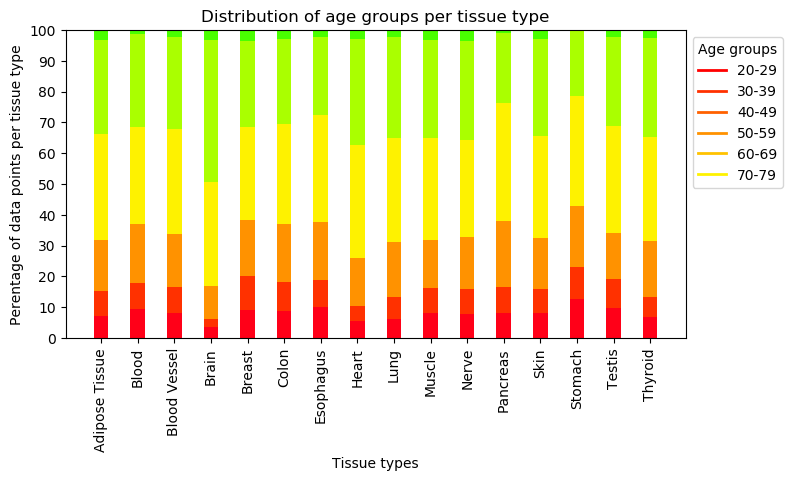

In [7]:
import matplotlib as mpl
from matplotlib.lines import Line2D
%run Final_source_code/AgeGroupViz.py

#### Visualization #2: Differential Gene Expression Analysis

#### ML/Stats #1: Traditional Classification

#### ML/Stats #2: Deep Learning

#### ML/Stats #3: Primary Hypotheses Testing